In [29]:
library(tidyverse, warn.conflicts = FALSE)

# library to read matlab data formats into R
library(reshape2)
library(lubridate)

# set strings as factors to false
options(stringsAsFactors = FALSE)

# READ CSV ERA5 from data pipeline

In [30]:
#wind_ds_2 <- read.csv("../DATA/ERA5_combined_wind_2.csv")
#wind_ds_2$time = parse_date_time(wind_ds_2$time ,orders = "%Y-%m-%d H:M:S")+200000

In [31]:
wind_ds_1 <- read.csv("../DATA/ERA5_combined_wind_1.csv")
wind_ds_2 <- read.csv("../DATA/ERA5_combined_wind_2.csv")

# adding time so all data has matching months, even those on last day of previous
# NOTE: MIGHT NEED TO DO TEMPORAL INTERPOLATION vs NISKIN DATA INSTEAD
wind_ds_1$time = parse_date_time(wind_ds_1$time ,orders = "%Y-%m-%d")+200000
wind_ds_2$time = parse_date_time(wind_ds_2$time ,orders = "%Y-%m-%d H:M:S")+200000

### add new Date column (month resolution)

In [32]:
wind_ds_1_monthly <- wind_ds_1 %>%
  mutate(time_month = format(time, format = "%m-%Y"))
wind_ds_2_monthly <- wind_ds_2 %>%
  mutate(time_month = format(time, format = "%m-%Y"))

In [33]:
head(wind_ds_1_monthly$time_month)
head(wind_ds_2_monthly$time_month)

[1] "01-1979" "02-1979" "03-1979" "04-1979" "05-1979" "06-1979"

[1] "01-1979" "02-1979" "03-1979" "04-1979" "05-1979" "06-1979"

In [34]:
wind_ds <- left_join(wind_ds_1_monthly, wind_ds_2_monthly, by = "time_month")

# read NISKIN data (from csv)

other datasets:
- PINTDF_integratedChlorophyll.csv
- MLD2EuZ_2.csv
- biogeochembact_dtypes.csv


In [35]:
niskin_ds <- read.csv("../../VeryNEWESTCariacoData/niskin_dtypes.csv")

In [36]:
niskin_ds$DATE <- paste(niskin_ds$Year,'-',niskin_ds$Month,'-',niskin_ds$Day, sep='')

# interpolate niskin_ds

In [37]:
# Function to read specific verfication type from dataset

prepdataframe <- function(variable='', datasource='niskin'){
    if(datasource=='niskin'){
    DF <- niskin_ds
    DF$date <- as.Date(DF$DATE, format="%Y-%m-%d")
    DF$depth <- DF$Depth_real
    #print(names(DF))
        
    VarDF <- DF %>%
      select(date, variable, depth) %>%
      gather(key='key',value = "value", -date, -depth)
    #head(VarDF)
    }
    
    return(VarDF)
}

In [38]:
# Interpolate
interpolateDF <- function(DF,func='oce-rr'){
    zz <- seq(0, 200, 1)
    
    if(func=='linear'){
        IntDF <- DF %>%
            group_by(date) %>%
            filter(sum(!is.na(value))>1) %>%
            do(data.frame(value_int = with(.,approx(depth, value, zz)), depth = zz)) 
        
        IntDF <- IntDF %>% 
              rename(
                value_int = value_int.y
                )
        IntDF$value_int.x <- NULL
        }
    
    else if(func=='oce-rr'){
        IntDF <- DF %>%
            group_by(date) %>%
            do(data.frame(value_int = with(.,oceApprox(depth, value, zz, "rr")), depth = zz)) 
        }
    
    return(IntDF)
}

In [39]:
interpolateNiskin <- function(var){
 
    niskin_dat <- prepdataframe(var)

    niskin_int <- interpolateDF(niskin_dat, 'linear')   
    
    niskin_sum <- niskin_int %>%
        group_by(date) %>%
        filter(depth<101) %>%
        filter(sum(is.na(value_int))<20) %>%
        summarize(value_sum = sum(value_int, na.rm=TRUE), 
                  var = mean(value_int, na.rm=TRUE),
                  #value_intgrtd = value_mean * 100,
                  NAs = sum(is.na(value_int)), .groups="keep")
    
    niskin_sum_monthly <- niskin_sum %>%
          mutate(time_month = format(date, format="%m-%Y"))

    
    return(niskin_sum_monthly)
}

## merge nisking to wind!

In [40]:
niskin_numeric = c('O2_ml_L',
                'O2_umol_kg',  
                'NO3_UDO',
                'PO4_UDO',
                'SiO4_UDO',
                'NH4_USF',
                'NO2_USF',
                'NO3_NO2_USF',
                'PO4_USF',
                'SiO4_USF',
                'pH',
                'Alkalinity_mol_kg',
                'Alkalinity_umol_kg',
                'TCO2',
                'fCO2',
                'pH_corrected',
                'TCO2_corrected',
                'fCO2_corrected',
                'Salinity_bottles',
                'Salinity_CTD',
                'Temperature',
                'Sigma_t',
                'TPP',
                'PIP',
                'POC_ug_kg',
                'PON_ug_kg',
                'POC_ug_L',
                'PN_ug_L',
                'C_N_particulate',
                'DON',
                'DOP',
                'DOC',
                'TOC',
                'PrimaryProductivity',
                'Chlorophyll',
                'Phaeopigments',
                'Total_Prokaryotes',
                'Bact_Biomass_mgC_m3',
                'Bact_Biomass_uMC')

In [41]:
niskin_temp_store = list()

for (variable in niskin_numeric) {
    print(variable)
    dat <- interpolateNiskin(variable)
    niskin_temp_store[[variable]] <- data.frame(dat_var = dat$var, time_month = dat$time_month)
    names(niskin_temp_store[[variable]])[1] <- variable
    #print(head(niskin_temp_store[[variable]]))
}

[1] "O2_ml_L"


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(variable)` instead of `variable` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



[1] "O2_umol_kg"
[1] "NO3_UDO"
[1] "PO4_UDO"
[1] "SiO4_UDO"
[1] "NH4_USF"
[1] "NO2_USF"
[1] "NO3_NO2_USF"
[1] "PO4_USF"
[1] "SiO4_USF"
[1] "pH"
[1] "Alkalinity_mol_kg"
[1] "Alkalinity_umol_kg"
[1] "TCO2"
[1] "fCO2"
[1] "pH_corrected"
[1] "TCO2_corrected"
[1] "fCO2_corrected"
[1] "Salinity_bottles"
[1] "Salinity_CTD"
[1] "Temperature"
[1] "Sigma_t"
[1] "TPP"
[1] "PIP"
[1] "POC_ug_kg"
[1] "PON_ug_kg"
[1] "POC_ug_L"
[1] "PN_ug_L"
[1] "C_N_particulate"
[1] "DON"
[1] "DOP"
[1] "DOC"
[1] "TOC"
[1] "PrimaryProductivity"
[1] "Chlorophyll"
[1] "Phaeopigments"
[1] "Total_Prokaryotes"
[1] "Bact_Biomass_mgC_m3"
[1] "Bact_Biomass_uMC"


In [42]:
niskin_intrp <- niskin_temp_store %>% 
    reduce(left_join, by = "time_month")

In [43]:
head(niskin_intrp)

,O2_ml_L,time_month,O2_umol_kg,NO3_UDO,PO4_UDO,SiO4_UDO,NH4_USF,NO2_USF,NO3_NO2_USF,PO4_USF,⋯,DON,DOP,DOC,TOC,PrimaryProductivity,Chlorophyll,Phaeopigments,Total_Prokaryotes,Bact_Biomass_mgC_m3,Bact_Biomass_uMC
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.066699,11-1995,177.2776,0.9217535,0.06162603,2.127115,NA,NA,NA,NA,⋯,NA,NA,78.70598,NA,NA,0.1793046,0.2700351,NA,NA,NA
2,3.438551,12-1995,149.8085,3.0948845,0.21142690,3.868919,NA,NA,NA,NA,⋯,NA,NA,NA,NA,0.4826918,0.1150949,0.1636278,0.7002847,2.131909,0.1776498
3,3.405264,01-1996,148.3119,7.5116266,0.30383795,4.868135,NA,NA,NA,NA,⋯,NA,NA,81.52567,NA,2.0569311,0.5825762,0.3451711,3.0429052,9.928947,0.8274119
4,3.304298,02-1996,143.9005,6.8777834,0.32541078,4.052312,NA,NA,NA,NA,⋯,NA,NA,70.76477,NA,1.2175528,0.3497634,0.2855399,2.5915307,8.455257,0.7046181
5,3.412656,03-1996,148.5819,6.5870977,0.33615601,5.161176,NA,NA,NA,NA,⋯,NA,NA,NA,NA,1.5397245,0.6365204,0.3778061,NA,NA,NA
6,3.569975,04-1996,155.4296,6.7700114,0.36042125,3.744388,NA,NA,NA,NA,⋯,NA,NA,89.78809,NA,0.9200121,2.2452814,1.3622393,1.6907867,5.531503,0.4609772


# MERGEEEEEEEEE

In [44]:
# here
ds_wind_niskin <- merge(wind_ds, niskin_intrp, all=TRUE)

In [45]:
names(ds_wind_niskin)

[1] "time_month"                                              
 [2] "time.x"                                                  
 [3] "X10m_u_component_of_wind"                                
 [4] "X10m_v_component_of_neutral_wind"                        
 [5] "X10m_v_component_of_wind"                                
 [6] "X10m_wind_speed"                                         
 [7] "X2m_temperature"                                         
 [8] "benjamin_feir_index"                                     
 [9] "coefficient_of_drag_with_waves"                          
[10] "instantaneous_eastward_turbulent_surface_stress"         
[11] "instantaneous_northward_turbulent_surface_stress"        
[12] "lake_mix_layer_depth"                                    
[13] "lake_mix_layer_temperature"                              
[14] "mean_wave_period"                                        
[15] "medium_cloud_cover"                                      
[16] "sea_surface_temperature"                                 
[17] "surface_pressure"                                        
[18] "v_component_stokes_drift"                                
[19] "time.y"                                                  
[20] "clear_sky_direct_solar_radiation_at_surface"             
[21] "evaporation"                                             
[22] "instantaneous_10m_wind_gust"                             
[23] "instantaneous_large_scale_surface_precipitation_fraction"
[24] "large_scale_precipitation"                               
[25] "mean_evaporation_rate"                                   
[26] "mean_runoff_rate"                                        
[27] "mean_total_precipitation_rate"                           
[28] "northward_turbulent_surface_stress"                      
[29] "runoff"                                                  
[30] "sub_surface_runoff"                                      
[31] "surface_runoff"                                          
[32] "surface_sensible_heat_flux"                              
[33] "total_precipitation"                                     
[34] "O2_ml_L"                                                 
[35] "O2_umol_kg"                                              
[36] "NO3_UDO"                                                 
[37] "PO4_UDO"                                                 
[38] "SiO4_UDO"                                                
[39] "NH4_USF"                                                 
[40] "NO2_USF"                                                 
[41] "NO3_NO2_USF"                                             
[42] "PO4_USF"                                                 
[43] "SiO4_USF"                                                
[44] "pH"                                                      
[45] "Alkalinity_mol_kg"                                       
[46] "Alkalinity_umol_kg"                                      
[47] "TCO2"                                                    
[48] "fCO2"                                                    
[49] "pH_corrected"                                            
[50] "TCO2_corrected"                                          
[51] "fCO2_corrected"                                          
[52] "Salinity_bottles"                                        
[53] "Salinity_CTD"                                            
[54] "Temperature"                                             
[55] "Sigma_t"                                                 
[56] "TPP"                                                     
[57] "PIP"                                                     
[58] "POC_ug_kg"                                               
[59] "PON_ug_kg"                                               
[60] "POC_ug_L"                                                
[61] "PN_ug_L"                                                 
[62] "C_N_particulate"                                         
[63] "DON"                       

In [72]:
write.csv(ds_wind_niskin, "Wind_Niskin_Merged_monthly.csv")

Warning message:
“Removed 274 rows containing missing values (geom_point).”


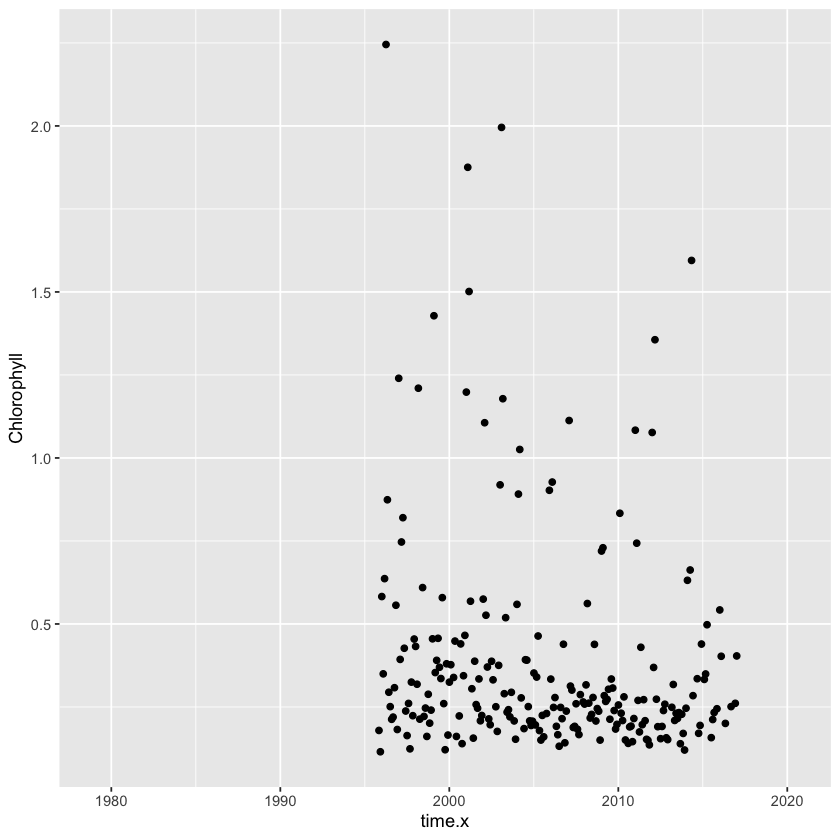

In [69]:
ggplot(ds_wind_niskin, aes(x=time.x, y=Chlorophyll)) + geom_point()

# TODO
- merge MLD2EuZ as well
- do prelim analysis following Esteban's script (choose only a few variables!)
- other data possible to include:
    - HPLC
    - Biogechmistry
    - Phytoplankton Counts
    - Zooplankton data
    - some proxy for SARDINES?? Landing numbers?

# MERGE MLD 2 EuZ DATA AS WELL

In [16]:
MLD2EuZ <- read.csv("../../PrelimDataExploration/MLD2EuZ_2.csv")

In [17]:
head(MLD2EuZ)

,X,CruiseID,Date,MLD2015,MLD2019,x0.1,x1,x10,X21degC,X22degC
,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,1,93HG_001,1995-11-08,NA,24.138,NA,NA,NA,130,118
2,2,93HG_002,1995-12-13,NA,18.103,NA,NA,NA,114,94
3,3,93HG_003,1996-01-12,36,10.057,NA,NA,NA,102,62
4,4,93HG_004,1996-02-13,28,8.046,NA,NA,NA,94,66
5,5,93HG_005,1996-03-13,28,10.057,NA,NA,NA,48,24
6,6,93HG_006,1996-04-16,32,7.040,NA,NA,NA,48,26


In [19]:
MLD2EuZ$date <- as.Date(MLD2EuZ$Date, format="%Y-%m-%d")

In [20]:
MLD2EuZ_2 <- MLD2EuZ %>%
          mutate(time_month = format(date, format="%m-%Y"))

In [27]:
MLD21deg <- MLD2EuZ_2[c(5,9,12)]

In [ ]:
# here
ds_wind_niskin <- merge(wind_ds, niskin_intrp, all=TRUE)

In [47]:
ds_wind_mld <- merge(ds_wind_niskin, MLD21deg, all=TRUE)

In [49]:
names(ds_wind_mld)

[1] "time_month"                                              
 [2] "time.x"                                                  
 [3] "X10m_u_component_of_wind"                                
 [4] "X10m_v_component_of_neutral_wind"                        
 [5] "X10m_v_component_of_wind"                                
 [6] "X10m_wind_speed"                                         
 [7] "X2m_temperature"                                         
 [8] "benjamin_feir_index"                                     
 [9] "coefficient_of_drag_with_waves"                          
[10] "instantaneous_eastward_turbulent_surface_stress"         
[11] "instantaneous_northward_turbulent_surface_stress"        
[12] "lake_mix_layer_depth"                                    
[13] "lake_mix_layer_temperature"                              
[14] "mean_wave_period"                                        
[15] "medium_cloud_cover"                                      
[16] "sea_surface_temperature"                                 
[17] "surface_pressure"                                        
[18] "v_component_stokes_drift"                                
[19] "time.y"                                                  
[20] "clear_sky_direct_solar_radiation_at_surface"             
[21] "evaporation"                                             
[22] "instantaneous_10m_wind_gust"                             
[23] "instantaneous_large_scale_surface_precipitation_fraction"
[24] "large_scale_precipitation"                               
[25] "mean_evaporation_rate"                                   
[26] "mean_runoff_rate"                                        
[27] "mean_total_precipitation_rate"                           
[28] "northward_turbulent_surface_stress"                      
[29] "runoff"                                                  
[30] "sub_surface_runoff"                                      
[31] "surface_runoff"                                          
[32] "surface_sensible_heat_flux"                              
[33] "total_precipitation"                                     
[34] "O2_ml_L"                                                 
[35] "O2_umol_kg"                                              
[36] "NO3_UDO"                                                 
[37] "PO4_UDO"                                                 
[38] "SiO4_UDO"                                                
[39] "NH4_USF"                                                 
[40] "NO2_USF"                                                 
[41] "NO3_NO2_USF"                                             
[42] "PO4_USF"                                                 
[43] "SiO4_USF"                                                
[44] "pH"                                                      
[45] "Alkalinity_mol_kg"                                       
[46] "Alkalinity_umol_kg"                                      
[47] "TCO2"                                                    
[48] "fCO2"                                                    
[49] "pH_corrected"                                            
[50] "TCO2_corrected"                                          
[51] "fCO2_corrected"                                          
[52] "Salinity_bottles"                                        
[53] "Salinity_CTD"                                            
[54] "Temperature"                                             
[55] "Sigma_t"                                                 
[56] "TPP"                                                     
[57] "PIP"                                                     
[58] "POC_ug_kg"                                               
[59] "PON_ug_kg"                                               
[60] "POC_ug_L"                                                
[61] "PN_ug_L"                                                 
[62] "C_N_particulate"                                         
[63] "DON"                       

# TRIM DOWN DATAFRAME TO 7 - 10 columns

In [57]:
min_ds_wind_mld = subset(ds_wind_mld, select = c(X10m_u_component_of_wind, X10m_v_component_of_wind, X2m_temperature,
                                                     sea_surface_temperature, evaporation, total_precipitation, 
                                                     Temperature, Chlorophyll, Phaeopigments,PrimaryProductivity,
                                                     MLD2019, X21degC
                                                    ))  

In [58]:
head(min_ds_wind_mld)

,X10m_u_component_of_wind,X10m_v_component_of_wind,X2m_temperature,sea_surface_temperature,evaporation,total_precipitation,Temperature,Chlorophyll,Phaeopigments,PrimaryProductivity,MLD2019,X21degC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,-5.555541,-3.383509,297.3916,297.8951,-0.002714400,1.637593e-04,NA,NA,NA,NA,NA,NA
2,-6.579281,-3.204941,298.4602,299.0524,-0.003747128,9.136318e-05,NA,NA,NA,NA,NA,NA
3,-5.772392,-3.310524,298.2949,298.8716,-0.002861220,4.597852e-05,NA,NA,NA,NA,NA,NA
4,-6.766924,-3.395296,298.1166,298.3931,-0.003052045,1.876352e-04,NA,NA,NA,NA,NA,NA
5,-6.501889,-3.117997,297.8933,297.7979,-0.002054193,1.369302e-04,NA,NA,NA,NA,NA,NA
6,-6.073257,-3.404279,297.6947,298.1369,-0.002788302,1.028873e-04,NA,NA,NA,NA,NA,NA


In [59]:
write.csv(min_ds_wind_mld, "12DS_WIND_NISKING_MLD_merge.csv")

In [51]:
niskinVSu10 <- cor(ds_wind_niskin[,-1], method = "pearson", use="pairwise.complete.obs")[1,]

ERROR: Error in cor(ds_wind_niskin[, -1], method = "pearson", use = "pairwise.complete.obs"): 'x' must be numeric


In [36]:
names(niskinVSu10_df)[0]

ERROR: Error in eval(expr, envir, enclos): object 'niskinVSu10_df' not found


In [37]:
niskinVSu10_df <- as.data.frame(niskinVSu10, keep.rownames = TRUE)

names(niskinVSu10_df)[1] <- "correlation"

niskinVSu10_df <- tibble::rownames_to_column(niskinVSu10_df, "var")


In [38]:
str(niskinVSu10_df)
head(niskinVSu10_df)

'data.frame':	40 obs. of  2 variables:
 $ var        : chr  "u10" "O2_ml_L" "O2_umol_kg" "NO3_UDO" ...
 $ correlation: num  1 -0.336 -0.337 0.509 0.373 ...


,var,correlation
,<chr>,<dbl>
1,u10,1.0000000
2,O2_ml_L,-0.3357260
3,O2_umol_kg,-0.3374663
4,NO3_UDO,0.5091092
5,PO4_UDO,0.3728885
6,SiO4_UDO,0.1812208


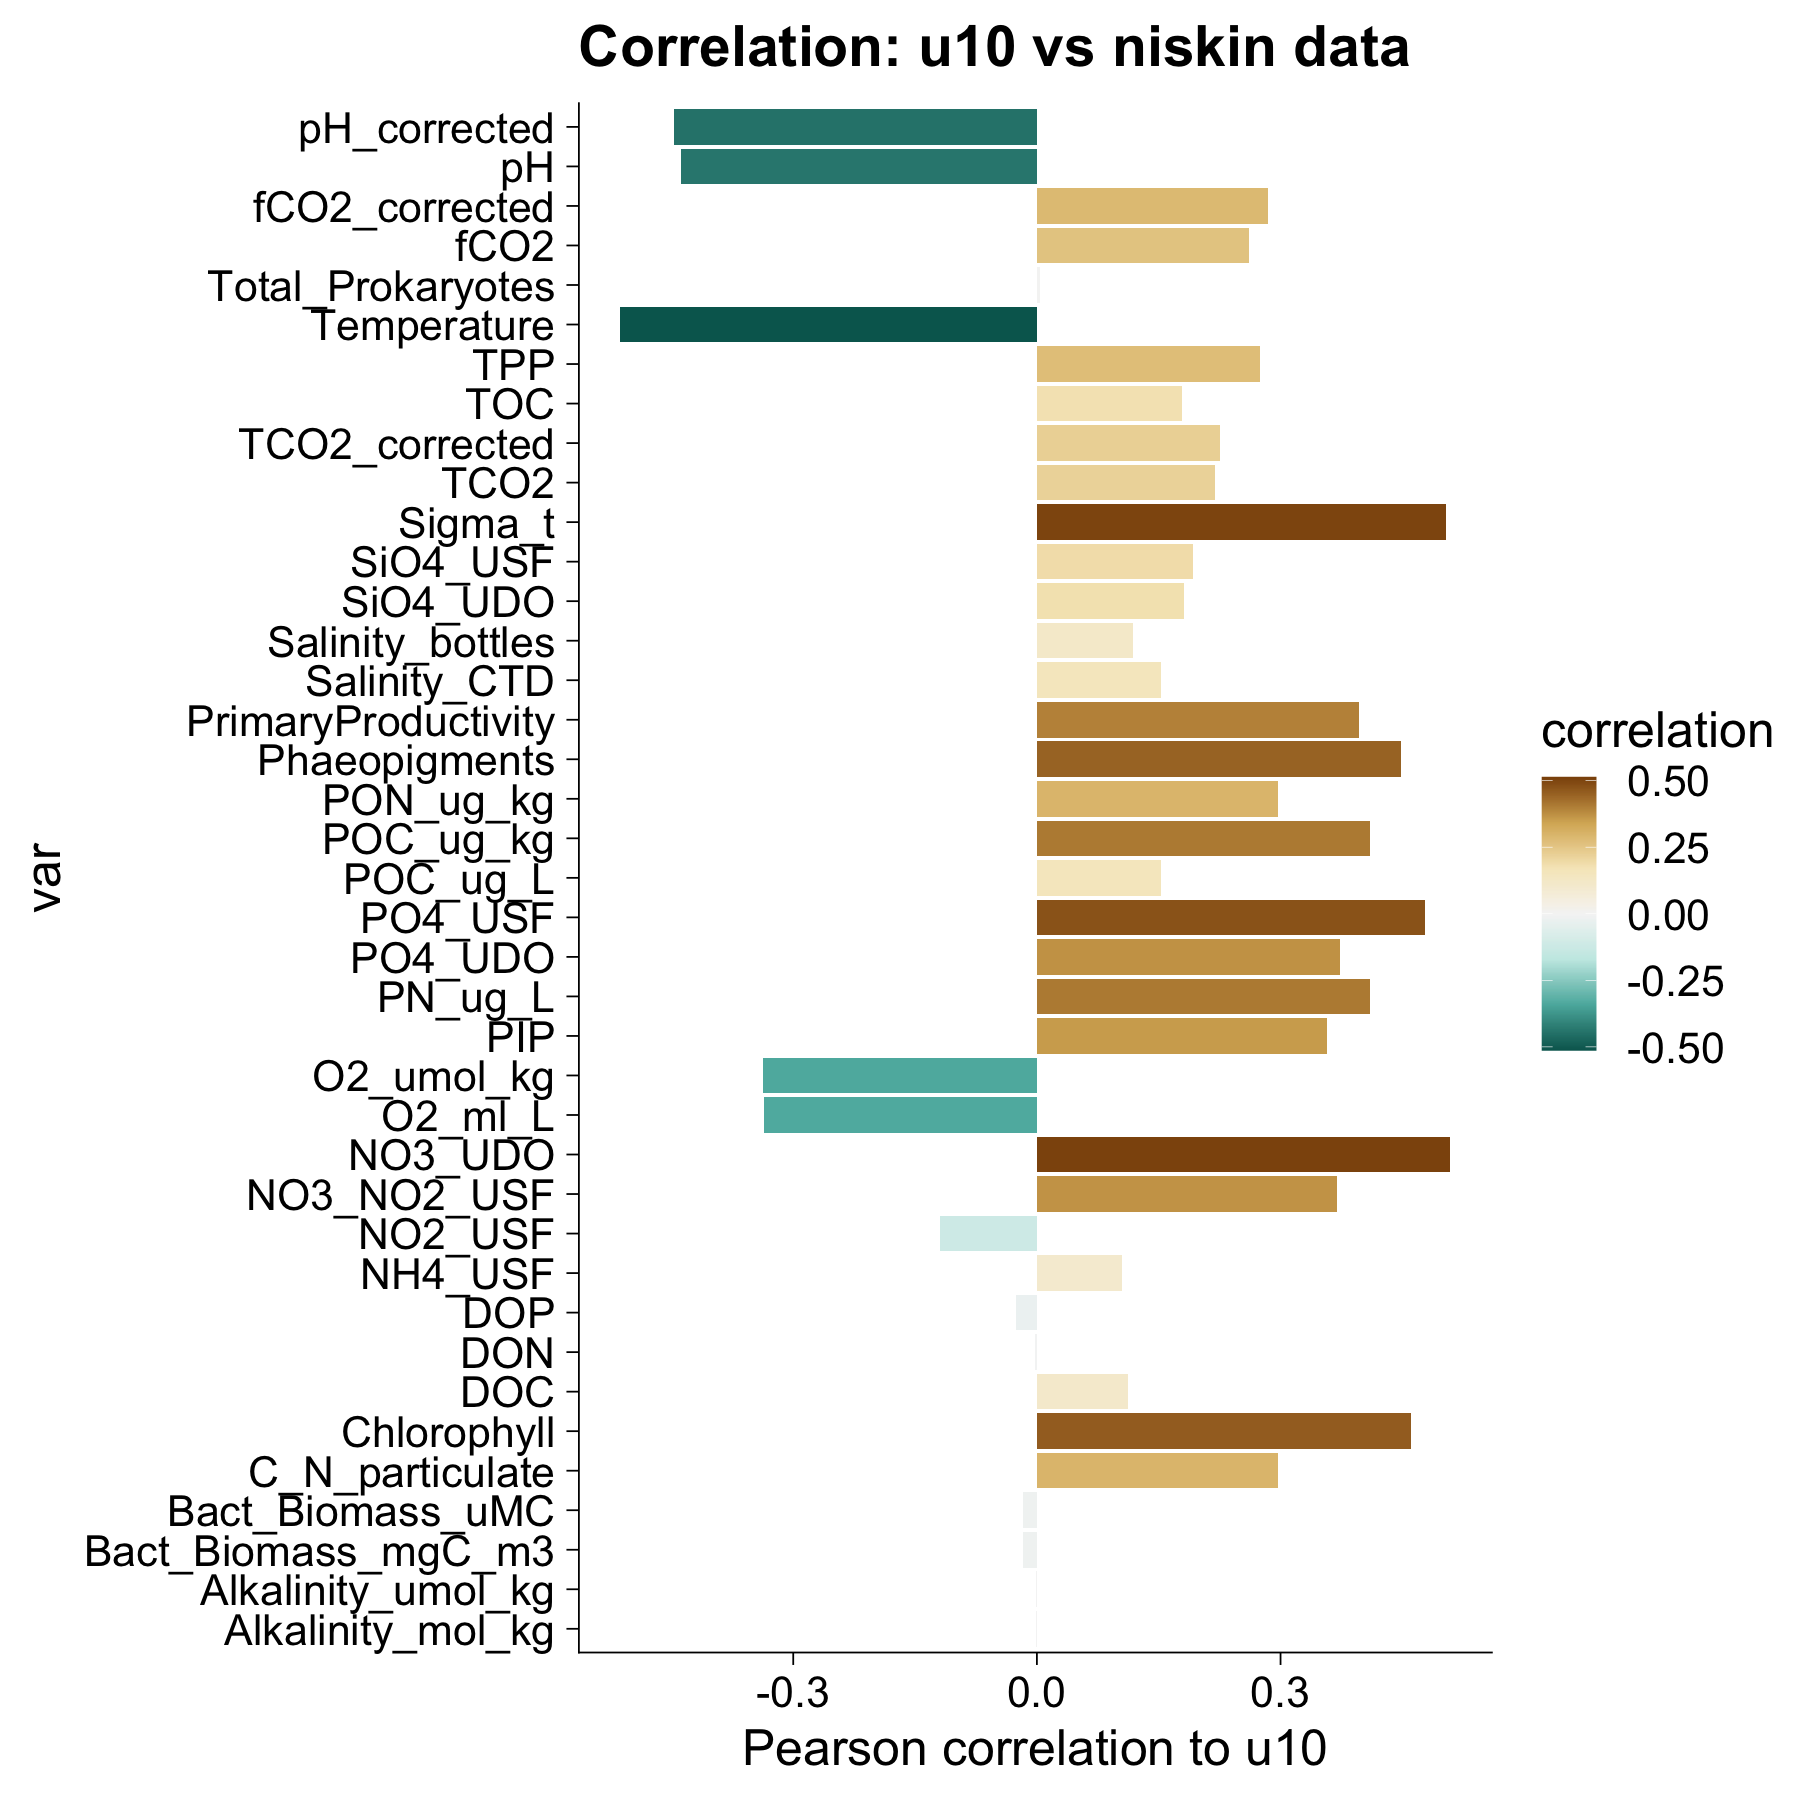

In [56]:
options(repr.plot.width=15, repr.plot.height=15)

limit <- max(abs(niskinVSu10_df[-1,]$correlation)) * c(-1, 1)

ggplot(data=niskinVSu10_df[-1,], aes(x=var, y=correlation, fill=correlation)) + 
    geom_bar(stat="identity") + ylab("Pearson correlation to u10") +
    theme_cowplot(font_size=30) + coord_flip() + ggtitle("Correlation: u10 vs niskin data") + 
    scale_fill_distiller(type='div', limit = limit) 

In [52]:
# ggsave('u10vsNiskin_correlation_plot.pdf', width=15, height=15)

In [ ]:
# do i need this?

In [17]:
getWindData <- function(windvar){
    
    wind_ds_var <- wind_ds_monthly %>%
          select(time_month, windvar)
    
    return(na.omit(wind_ds_var))
}

In [18]:
interpolatedmerge <- function(var, windvar){
 
    niskin_dat <- prepdataframe(var)

    niskin_int <- interpolateDF(niskin_dat, 'linear')   
    
    niskin_sum <- niskin_int %>%
        group_by(date) %>%
        filter(depth<101) %>%
        filter(sum(is.na(value_int))<20) %>%
        summarize(value_sum = sum(value_int, na.rm=TRUE), 
                  value_mean = mean(value_int, na.rm=TRUE),
                  value_intgrtd = value_mean * 100,
                  NAs = sum(is.na(value_int)), .groups="keep")
    
    niskin_sum_monthly <- niskin_sum %>%
          mutate(time_month = format(date, format="%m-%Y"))
    
    wind_ds_var <- wind_ds_monthly %>%
          select(time_month, windvar)
    
    wind_niskin <- merge(wind_ds_var, niskin_sum_monthly, all=TRUE)
    
    wind_niskin$time <- parse_date_time(wind_niskin$time_month, orders="%m-%Y")
    
    wind_niskin_addyear <- wind_niskin %>%
        mutate(year = format(date, format="%Y")) %>%
        group_by(year) %>%
        mutate(value_yearly_mean = mean(value_intgrtd, na.rm=TRUE))

    
    return(wind_niskin_addyear)
}